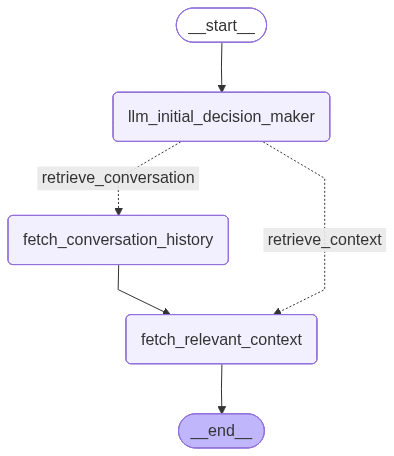

In [1]:
from typing import TypedDict, Annotated, Optional, List, Dict
from dotenv import load_dotenv
from dataclasses import dataclass, field
from langgraph.runtime import Runtime
from langgraph.graph import StateGraph, START, END
from enum import Enum

from prompts import Prompts
from chat_models import ChatModels
from utils import typed_dict_to_prompt

load_dotenv()


class Nodes(Enum):
    LLM_INITIAL_DECISION_MAKER = "llm_initial_decision_maker"
    FETCH_RELEVANT_CONTEXT = "fetch_relevant_context"
    VERIFY_CONVERSATION_HISTORY = "verify_conversation_history"
    FETCH_CONVERSATION_HISTORY = "fetch_conversation_history"


@dataclass(kw_only=True)
class AgentContext:
    chat_model: ChatModels = field(default=ChatModels())
    # pinecone_db: PineconeClient

    # To be passed during every run
    user_id: str
    video_id: str
    chat_id: str


class DecisionState(TypedDict):
    requires_previous_conversations: Annotated[
        bool, "Indicates if the current query depends on previous dialogue context."
    ]

    # Video segment targeting information
    start_time: Annotated[
        Optional[int],
        "Start time (in minutes) of the target video segment, if specified.",
    ]
    end_time: Annotated[
        Optional[int],
        "End time (in minutes) of the target video segment, if specified.",
    ]
    user_query: Annotated[str, "Raw text of the user’s latest message or instruction."]


class AgentState(DecisionState):
    relevant_context: List[Dict]
    conversation_history: List[str]
    requires_refetching: bool


async def llm_initial_decision_maker(
    state: AgentState, runtime: Runtime[AgentContext]
) -> dict:
    """Returns the updated decision state directly from llm."""

    chat_model = runtime.context.chat_model
    user_query = state["user_query"]
    instruction = typed_dict_to_prompt(DecisionState)
    prompt = Prompts.DECISION_PROMPT.value.format(
        query=user_query, instruction=instruction
    )
    decision_dict = await chat_model.call_llm(prompt, is_json=True)
    return decision_dict


async def check_previous_conversation_requirement(state: AgentState) -> str:
    requires_previous_conversations = state["requires_previous_conversations"]
    if requires_previous_conversations:
        return "retrieve_conversation"
    else:
        return "retrieve_context"


async def fetch_relevant_context(
    state: AgentState, runtime: Runtime[AgentContext]
) -> dict:
    context: AgentContext = runtime.context
    user_query = state["user_query"]
    pinecone_client = context.pinecone_db
    relevant_context: List[Dict] = await pinecone_client.retrieve_context(
        query=user_query, user_id=context.user_id, video_id=context.video_id, k=4
    )
    # The value of k can be modified based on the user specific instruction
    return {"relevant_context": relevant_context}


async def fetch_conversation_history(
    state: AgentState, runtime: Runtime[AgentContext]
) -> dict:
    context = runtime.context
    pass
    # Since this contains the memory part, this will be done later


graph = StateGraph(state_schema=AgentState, context_schema=AgentContext)

graph.add_node(Nodes.LLM_INITIAL_DECISION_MAKER.value, llm_initial_decision_maker)
graph.add_node(Nodes.FETCH_RELEVANT_CONTEXT.value, fetch_relevant_context)
graph.add_node(Nodes.FETCH_CONVERSATION_HISTORY.value, fetch_conversation_history)


graph.add_edge(START, Nodes.LLM_INITIAL_DECISION_MAKER.value)
graph.add_conditional_edges(
    Nodes.LLM_INITIAL_DECISION_MAKER.value,
    check_previous_conversation_requirement,
    {
        "retrieve_conversation": Nodes.FETCH_CONVERSATION_HISTORY.value,
        "retrieve_context": Nodes.FETCH_RELEVANT_CONTEXT.value,
    },
)
graph.add_edge(
    Nodes.FETCH_CONVERSATION_HISTORY.value, Nodes.FETCH_RELEVANT_CONTEXT.value
)
graph.add_edge(Nodes.FETCH_RELEVANT_CONTEXT.value, END)


app = graph.compile()
app

In [ ]:
app.astream_events(version='v2')

In [1]:
chunk = {'llm_initial_decision_maker': {'requires_previous_conversations': False, 'start_time': None, 'end_time': None, 'user_query': 'What is the video about?'}}

In [2]:
list(chunk.values())[0].get('next_node')